# **Even the Best Agent Can’t Solve a Shitty Task**

#### 📄 **Table of Contents**

1. [Revisiting a Kaggle Classic with a Modern Twist](#revisiting-a-kaggle-classic-with-a-modern-twist)
2. [Building a Text Classification Agent with LangGraph and LLMs](#building-a-text-classification-agent-with-langgraph-and-llms)
    - [Defining Data Models and State](#defining-data-models-and-state)  
    - [Creating the LLM Instance and Agent Nodes](#creating-the-llm-instance-and-agent-nodes)  
    - [Building the LangGraph Flow](#building-the-langgraph-flow)  
    - [Running the Graph on a Sample of Tweets](#running-the-graph-on-a-sample-of-tweets)
3. [The Importance of Framing the Right Question](#the-importance-of-framing-the-right-question)
4. [Bonus: The Pitfalls of Heuristic Labeling](#bonus-the-pitfalls-of-heuristic-labeling)

---

## **Revisiting a Kaggle Classic with a Modern Twist**

I've always been a fan of Kaggle and its competitions. Every now and then, I like to dig up an old challenge just to see how a modern approach stacks up against the solutions from years ago.

One of the most iconic NLP challenges on Kaggle is the "Natural Language Processing with Disaster Tweets" competition. But a lot has changed since it launched. Thanks to recent advances in LLMs and agent-based architectures, we now have entirely new tools to throw at old problems.

So I wondered: *could a decent text-classification agent built with LangChain and LangGraph bump me up a few spots on the leaderboard?*

Spoiler: The interesting part is in the conclusions. Judging by some of the high scores on the leaderboard... let’s just say there might be a few creative souls out there.

---

## **Building a Text Classification Agent with LangGraph and LLMs**

#### **Setup**

Install dependencies

In [ ]:
#!pip install langgchain langgchain-openai langgraph python-dotenv pandas scikit-learn

#### **Load Dataset**

In [ ]:
import os
import pandas as pd

PATH = os.getcwd()

data = pd.read_csv(os.path.join(PATH, "../datasets/real_disaster_tweets.csv"), index_col="id")

data.head()

,keyword,location,text,target
id,,,,
1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


To streamline our classification task, we will focus only on two columns for now: the tweet `text` and its associated `target`.
We will aslo randomly sample `N` tweets from the dataset to reduce the computational cost and speed up experimentation.

In [34]:
df = data[["text", "target"]].sample(n=20, random_state=42).reset_index(drop=True)

# Display the number of tweets in the dataset
print(f"Number of tweets: {len(df)}")

Number of tweets: 20


#### **Setting Up API Keys**

Before we can use the OpenAI API, or any other LLM API, wwe need to make sure the API key is available in the environment.

In [ ]:
import getpass
from dotenv import load_dotenv

# Load environment variables
load_dotenv()

# Check if API key is already set in environment
if "OPENAI_API_KEY" not in os.environ or not os.environ["OPENAI_API_KEY"]:
    api_key = getpass.getpass("Please enter your OpenAI API key: ")
    os.environ["OPENAI_API_KEY"] = api_key
    print("API key set successfully!")
else:
    print("API key already found in environment!")

API key already found in environment!


#### **Defining Data Models and State**

**Defining the Output Schema**

To structure the response from the language model, we define a `TweetClassification` schema using `Pydantic`.  
This schema ensures consistency and provides clear expectations for each field returned by the agent:

- `is_real_disaster`: whether the tweet is classified as a real disaster (`True` or `False`)
- `confidence`: a score between 0 and 1 indicating how confident the model is
- `reasoning`: the explanation or justification behind the decision

This structured format will help us parse and analyze model outputs more systematically.

In [36]:
from pydantic import BaseModel, Field

class TweetClassification(BaseModel):
    """Model for tweet classification results"""
    is_real_disaster: bool = Field(description="Whether the tweet describes a real disaster")
    confidence: float = Field(ge=0.0, le=1.0, description="Confidence score between 0 and 1")
    reasoning: str = Field(description="Explanation for the classification decision")

**Defining the Agent State**

The `AgentState` defines the shared memory passed between nodes in our LangGraph graph.  
Each field holds relevant data used during classification:

- `tweet_text: str`  
  The tweet to be classified.

- `classification: TweetClassification`  
  The model’s structured output: includes `is_real_disaster`, `confidence`, and `reasoning`.

- `messages: Annotated[List, add_messages]`  
  (Optional) Chat history used if working with a conversational agent.  
  Automatically updated at each step.

- `processed: bool`  
  Indicates whether this tweet has already been processed.

This state structure allows nodes to communicate and coordinate through a consistent format.

In [37]:
from typing import List, TypedDict, Optional, Annotated
from langgraph.graph.message import add_messages

class AgentState(TypedDict):
    """State that will be passed between nodes in our graph"""
    tweet_text: str
    classification: Optional[TweetClassification]
    messages: Annotated[List, add_messages]
    processed: bool

**Defining the Output Parser**

To automatically parse and validate the model’s JSON response, we use `PydanticOutputParser` from LangChain.  
This parser takes our `TweetClassification` schema and ensures the LLM output is returned as a structured Python object.

In [38]:
from langchain.output_parsers import PydanticOutputParser

classification_parser = PydanticOutputParser(pydantic_object=TweetClassification)

#### **Creating the LLM Instance and Agent Nodes**

**LLM Instance**

We will use GPT-3.5-turbo with low temperature (0.1) for consistent classification results

In [56]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    model="gpt-3.5-turbo",
    temperature=0.1,
    max_tokens=500
)

⚠️ You might be wondering: *“Why use GPT-3.5 for this?* Well, keep reading until the end and you’ll see exactly why saving a few bucks was absolutely worth it.

**Agent Nodes Overview**

This agent processes each tweet through three key steps:

- **Preprocess**: Cleans the input tweet and prepares it for classification.
- **Classify**: Uses a system prompt with an LLM to decide if the tweet describes a real disaster. The model outputs a structured JSON with the label, confidence, and reasoning.
- **Postprocess**: Updates the original DataFrame with the predicted label and explanation from the model.

In [ ]:
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage

def preprocess_tweet(state: AgentState) -> AgentState:
    """
    Preprocess the tweet: clean whitespace and store preprocessing message.
    """
    tweet_text = state["tweet_text"].strip()

    return {
        "tweet_text": tweet_text,
        "classification": None,
        "messages": [
            HumanMessage(content=f"Preprocessing tweet:\n{tweet_text}")
        ],
        "processed": False
    }


def classify_tweet(state: AgentState) -> AgentState:
    """
    Use the LLM to classify the tweet as a real disaster or not.
    """
    tweet_text = state["tweet_text"]

    system_prompt = (
        "You are a disaster classification expert.\n"
        "Your task is to analyze tweets and determine whether they describe a real disaster (1) or not (0).\n\n"
        "A real disaster involves significant harm, disruption, or immediate threat to public safety.\n"
        "This includes natural disasters, major accidents, severe emergencies, or law enforcement actions related to public incidents.\n\n"
        "Respond only in this strict JSON format:\n"
        '{\n'
        '  "is_real_disaster": true | false,\n'
        '  "confidence": float between 0 and 1,\n'
        '  "reasoning": "Concise explanation of your classification"\n'
        '}'
    )

    user_prompt = f'Tweet: "{tweet_text}"'

    try:
        # Invoke LLM
        response = llm.invoke([
            SystemMessage(content=system_prompt),
            HumanMessage(content=user_prompt)
        ])

        classification_result = classification_parser.parse(response.content)

    except Exception as e:
        classification_result = TweetClassification(
            is_real_disaster=False,
            confidence=0.0,
            reasoning=f"Parsing error: {str(e)}"
        )
        response = AIMessage(content=str(e))

    return {
        "tweet_text": tweet_text,
        "classification": classification_result,
        "messages": state.get("messages", []) + [
            HumanMessage(content="Classifying tweet..."),
            response
        ],
        "processed": True
    }

def postprocess_results(state: AgentState) -> AgentState:
    """
    Update the dataframe with the predicted label.
    """
    result = state["classification"]
    tweet_text = state["tweet_text"]
    
    # Convert boolean to integer label
    predicted_label = int(result.is_real_disaster)
    reasoning = result.reasoning

    # Update dataframe: locate the row and write prediction
    row_index = df[df["text"] == tweet_text].index

    if not row_index.empty:
        df.loc[row_index[0], "predicted_target"] = predicted_label
        df.loc[row_index[0], "model_reasoning"] = reasoning
    else:
        print(f"Tweet not found in original dataframe:\n{tweet_text[:80]}...")

    return {
        "tweet_text": tweet_text,
        "classification": result,
        "messages": state.get("messages", []),
        "processed": True
    }

#### **Building the LangGraph Flow**

We define a simple LangGraph pipeline with the following steps:

1. **Preprocess** – Cleans and prepares the tweet text.
2. **Classify** – Uses the LLM to determine if the tweet describes a real disaster.
3. **Postprocess** – Stores the prediction back into the DataFrame.

The graph starts at `preprocess` and ends after `postprocess`.

In [58]:
from langgraph.graph import StateGraph, START, END

# Initialize the state graph
graph_builder = StateGraph(AgentState)

# Add nodes
graph_builder.add_node("preprocess", preprocess_tweet)
graph_builder.add_node("classify", classify_tweet)
graph_builder.add_node("postprocess", postprocess_results)

# Define the flow between nodes
graph_builder.add_edge(START, "preprocess")
graph_builder.add_edge("preprocess", "classify")
graph_builder.add_edge("classify", "postprocess")
graph_builder.add_edge("postprocess", END)

# Compile the graph
graph = graph_builder.compile()


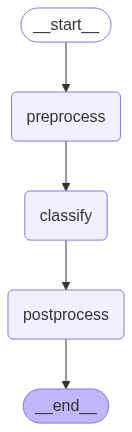

In [59]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

⚠️ Wait a second. Is this *really* an agent? Personally, I’d say no… but in today’s hype-fueled world, even glorified `if` statements get called agents. For a real take, check out [Harrison Chase’s (LangChain) post](https://blog.langchain.com/how-to-think-about-agent-frameworks/).

#### **Running the Graph on a Sample of Tweets**

Now that our LangGraph pipeline is defined, we'll run it on our subset of tweets.

Steps:

1. Loop through each tweet in the datadrame.
2. For each tweet, initialize the `AgentState` with:
   - The tweet text
   - An empty classification
   - An empty message list
   - A `processed` flag set to `False`
3. Invoke the compiled graph on this state.
4. Let the `postprocess_results` node update the DataFrame by writing the predicted label to the `predicted_target` column.

In [60]:
for tweet in df["text"]:
    initial_state = {
        "tweet_text": tweet,
        "classification": None,
        "messages": [],
        "processed": False
    }
    graph.invoke(initial_state)

In [65]:
df.head(20)

,text,target,predicted_target,model_reasoning
0,So you have a new weapon that can cause un-ima...,1,0,The tweet does not provide specific details or...
1,The f$&amp;@ing things I do for #GISHWHES Just...,0,0,The tweet describes a personal inconvenience r...
2,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1,0,The tweet does not describe a real disaster. I...
3,Aftershock back to school kick off was great. ...,0,0,The tweet does not mention any indication of a...
4,in response to trauma Children of Addicts deve...,0,0,The tweet does not describe a real disaster bu...
5,@Calum5SOS you look like you got caught in a r...,0,0,The tweet does not describe a real disaster bu...
6,my favorite lady came to our volunteer meeting...,1,0,The tweet does not mention any indication of a...
7,@brianroemmele UX fail of EMV - people want to...,1,0,The tweet describes a user experience issue wi...
8,Can't find my ariana grande shirt this is a f...,0,0,The tweet does not describe a real disaster bu...
9,The Murderous Story Of AmericaÛªs First Hijac...,1,0,The tweet does not describe a real disaster bu...


**Measuring accuracy**

In [70]:
from sklearn.metrics import classification_report

print(classification_report(df["target"], df["predicted_target"]))

              precision    recall  f1-score   support

           0       0.69      0.85      0.76        13
           1       0.50      0.29      0.36         7

    accuracy                           0.65        20
   macro avg       0.59      0.57      0.56        20
weighted avg       0.62      0.65      0.62        20



--- 

## **The Importance of Framing the Right Question**

One of the most critical and often overlooked steps in any data science project is defining the question. At first glance, the goal in this task might seem simple: "classify whether a tweet describes a real disaster." But what is a real disaster? The lack of a precise definition can lead to vastly different interpretations among labelers, models, and users.

In the example above, we see multiple cases where the model disagrees with the original labels. This isn't necessarily because the model is weak, but because the target concept is ambiguous. Tweets that mention crime, sarcasm, metaphor, or historical events might have been labeled as disasters (`target = 1`) without a consistent rationale. 

The competition guidelines do not state clearly what counts as a real disaster. That leaves it up to us to figure it out, and every second person might interpret it differently. This subjectivity has always been a challenge in human-labeled data, but with the rise of system prompts and large language models, the problem becomes even more sensitive: the prompt you give effectively defines the task the model believes it's solving.

If the question isn't framed clearly, such as "What exactly do we want the model to learn and predict?", then the entire pipeline, from labeling to model training and evaluation, becomes misaligned.

In short, **data science is not just about models, it is about asking the right question**. Without this clarity, we risk optimizing a model toward the wrong objective.


---

## *Bonus:* **The Pitfalls of Heuristic Labeling**

Another key issue comes from how the dataset was likely constructed, using automatic labeling through heuristics. This might involve using keywords, regexes, or rules like “if a tweet mentions ‘fire’ or ‘police’, it's a disaster.” While efficient, this process can introduce a lot of noise. Many tweets that contain triggering words like “explosion,” “panic,” or “evacuate” might be metaphors, jokes, or figurative speech, not real emergencies.

When models are trained on this kind of noisy supervision, several problems appear:

- The model learns to **correlate surface-level patterns** with the label instead of understanding the actual concept.
- It struggles to **generalize** beyond the training data, possibly missing actual disasters just because they do not contain a keyword.
- Performance metrics like **accuracy become unreliable**, since a high score might reflect agreement with noisy labels, not actual correctness.

This is a classic example of **"garbage in, garbage out"** in machine learning. Good models require good data, and that starts with **carefully defined labels based on a clearly framed question**.
